In [1]:
%tensorflow_version 2.1

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [75]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.python.keras import layers

In [79]:
# Print versions
!python --version
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)

Python 3.10.12
Numpy 1.23.5
TensorFlow 2.14.0


In [98]:
# Settings
nsamples = 5000     # Number of samples to use as a dataset
val_ratio = 0.2     # Percentage of samples that should be held for validation set
test_ratio = 0.2    # Percentage of samples that should be held for test set
tflite_model_name = 'sine_model'  # Will be given .tflite suffix
c_model_name = 'sine_model'       # Will be given .h suffix

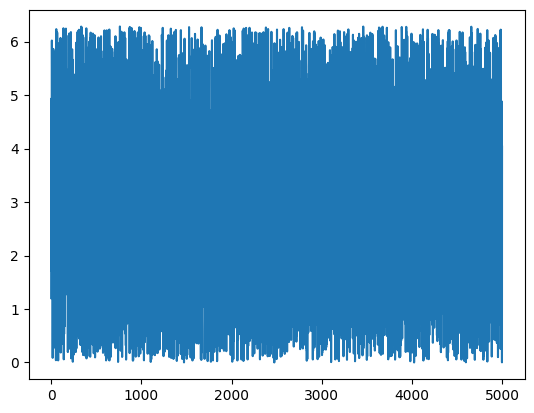

In [99]:
# Generate some random samples
np.random.seed(1234)
x_values = np.random.uniform(low=0, high=(2 * math.pi), size=nsamples)
plt.plot(x_values)

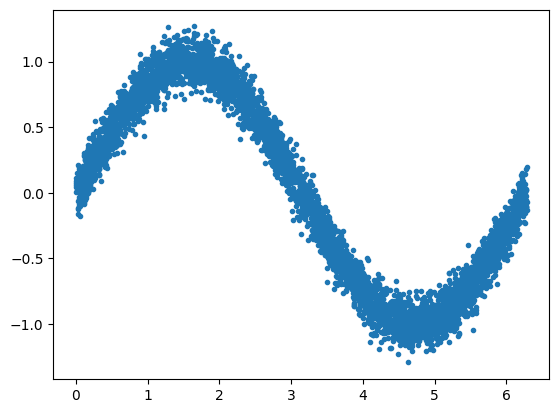

In [100]:
# Create a noisy sinewave with these values
y_values = np.sin(x_values) + (0.1 * np.random.randn(x_values.shape[0]))
plt.plot(x_values, y_values, '.')

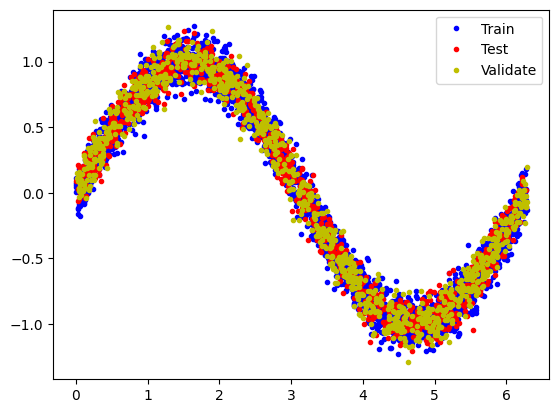

In [101]:
# Plit the dataset into training, validation, and test sets
val_split = int(val_ratio * nsamples)
test_split = int(val_split + (test_ratio * nsamples))
x_val, x_test, x_train = np.split(x_values, [val_split, test_split])
y_val, y_test, y_train = np.split(y_values, [val_split, test_split])

# Check that our splits add up correctly
assert(x_train.size + x_val.size + x_test.size) == nsamples

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_val, y_val, 'y.', label="Validate")
plt.legend()
plt.show()

In [102]:
# Create a model
model = tf.keras.Sequential()                                     #
model.add(layers.Dense(16, activation='relu', input_shape=(1,)))  # the input layer of 16 nodes (input is just one number - the value from 0 to 2*Pi)
model.add(layers.Dense(16, activation='relu'))                    # the inner layer of 16 nodes
model.add(layers.Dense(1))                                        # the output layer of 1 nodes giving the predicted value (a value in [-1,1])

In [103]:
# Build model
model.build((None, 1))

In [104]:
# View model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_12 (ModuleW  (None, 16)                32        
 rapper)                                                         
                                                                 
 module_wrapper_13 (ModuleW  (None, 16)                272       
 rapper)                                                         
                                                                 
 module_wrapper_14 (ModuleW  (None, 1)                 17        
 rapper)                                                         
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [105]:
# Add optimizer, loss function, and metrics to model and compile it
model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])

In [106]:
# Train model
history = model.fit(x_train,
                    y_train,
                    epochs=500,
                    batch_size=100,
                    validation_data=(x_val, y_val))

Epoch 1/500
30/30 [==============================] - 1s 9ms/step - loss: 0.5707 - mae: 0.5707 - val_loss: 0.5095 - val_mae: 0.5095
Epoch 2/500
30/30 [==============================] - 0s 4ms/step - loss: 0.5000 - mae: 0.5000 - val_loss: 0.4731 - val_mae: 0.4731
Epoch 3/500
30/30 [==============================] - 0s 4ms/step - loss: 0.4634 - mae: 0.4634 - val_loss: 0.4402 - val_mae: 0.4402
Epoch 4/500
30/30 [==============================] - 0s 4ms/step - loss: 0.4298 - mae: 0.4298 - val_loss: 0.4111 - val_mae: 0.4111
Epoch 5/500
30/30 [==============================] - 0s 3ms/step - loss: 0.3972 - mae: 0.3972 - val_loss: 0.3814 - val_mae: 0.3814
Epoch 6/500
30/30 [==============================] - 0s 5ms/step - loss: 0.3706 - mae: 0.3706 - val_loss: 0.3606 - val_mae: 0.3606
Epoch 7/500
30/30 [==============================] - 0s 4ms/step - loss: 0.3477 - mae: 0.3477 - val_loss: 0.3478 - val_mae: 0.3478
Epoch 8/500
30/30 [==============================] - 0s 4ms/step - loss: 0.3303 - m

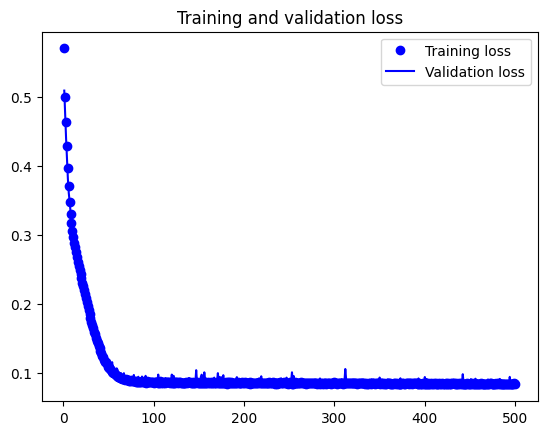

In [107]:
# Plot the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

32/32 [==============================] - 0s 2ms/step


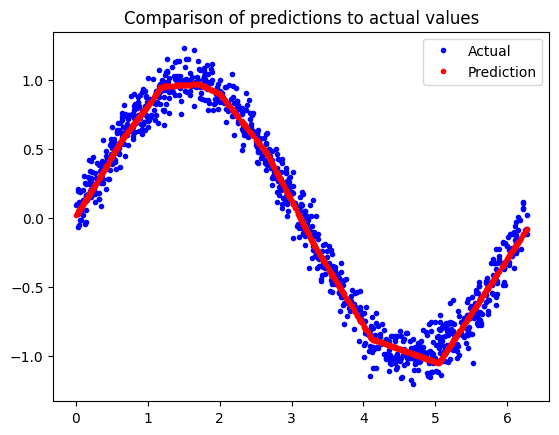

In [108]:
# Plot predictions against actual values
predictions = model.predict(x_test)

plt.clf()
plt.title("Comparison of predictions to actual values")
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Prediction')
plt.legend()
plt.show()

In [116]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]          # optimizes for size
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

3460

In [117]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [118]:
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))